In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [2]:
from pprint import pprint
from copy import deepcopy
from typing import Iterable, Callable, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

In [4]:
from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece, cal_curve, accuracy
from probcalkge import get_cls_name

In [5]:
from probcalkge.calmodels2 import get_calibrators
ds = get_datasets()
cals = get_calibrators()
kges = get_kgemodels()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [6]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.beta, cals.histbin], 
    datasets=[ds.fb13, ds.wn18, ds.yago39, ds.dp50, ds.kinship, ds.umls], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[brier_score, negative_log_loss, ks_error, ece]
    )

In [7]:
exp.load_trained_kges('../saved_models/trained_kges')

Loaded trained KG embedding models.


In [8]:
exp_res = exp.run_with_trained_kges()

training various calibrators for TransE on FB13k ...
training various calibrators for ComplEx on FB13k ...
training various calibrators for DistMult on FB13k ...
training various calibrators for HolE on FB13k ...
training various calibrators for TransE on WN11 ...
training various calibrators for ComplEx on WN11 ...
training various calibrators for DistMult on WN11 ...
training various calibrators for HolE on WN11 ...
training various calibrators for TransE on YAGO39 ...
training various calibrators for ComplEx on YAGO39 ...
training various calibrators for DistMult on YAGO39 ...
training various calibrators for HolE on YAGO39 ...
training various calibrators for TransE on DBpedia50 ...
training various calibrators for ComplEx on DBpedia50 ...
training various calibrators for DistMult on DBpedia50 ...
training various calibrators for HolE on DBpedia50 ...
training various calibrators for TransE on Kinship ...
training various calibrators for ComplEx on Kinship ...
training various cali

In [8]:
from sklearn.calibration import CalibrationDisplay


def plot_ds_kge_cals(data, kge, cals, ax=None):
    ax = plt.axes() if ax == None else ax

    for cal in cals:
        scores = kge.predict(data.X_test)
        probs = cal.predict(expit(scores))
        CalibrationDisplay.from_predictions(data.y_test, probs, ax=ax, name=cal.name)
    
    ax.set_title(f'{data.name}-{kge.name}')
    ax.legend()
    ax.get_legend().remove()
    ax.set(xlabel=None)
    ax.set(ylabel=None)
        

Text(0.02, 0.5, 'Fraction of Positives')

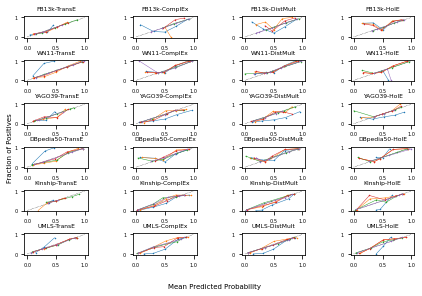

In [9]:
plt.rc('figure', dpi=260) # default for me was 75
plt.rc('figure', titlesize=7)
plt.rc('axes', labelsize=10)
plt.rc('axes', titlesize=6)
plt.rc('xtick', labelsize=5)
plt.rc('ytick', labelsize=5)
plt.rc('legend', fontsize=8)
plt.rc('lines', linewidth=0.5)
plt.rc('lines', markersize=0.5)

fig, axes = plt.subplots(6, 4)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
fig.tight_layout(h_pad=0.8)
for i, data in enumerate(exp.datasets):
    for j, kge in enumerate(exp.trained_kges[data.name].values()):
        cals = exp.trained_cals[data.name][kge.name].values()
        plot_ds_kge_cals(data, kge, cals, axes[i][j])
fig.supxlabel('Mean Predicted Probability')
fig.supylabel('Fraction of Positives')
# plt.legend()

In [47]:
def plot_metrics(metric):
    # plt.rc('figure', dpi=200) # default for me was 75
    plt.rc('axes', labelsize=5)
    plt.rc('axes', titlesize=18)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=13)
    plt.rc('legend', fontsize=10)
    plt.rc('lines', linewidth=2)
    plt.rc('lines', markersize=2)
    plt.rc('figure', titlesize=18)
    plt.rcParams['figure.subplot.wspace'] = 0.05

    # fig, axes = plt.subplots(2, 3)
    fig, axes = plt.subplots(1, 6, sharey=True)
    fig.set_size_inches(18.5, 3.0, forward=True)
    
    fig.supylabel(metric.__name__, fontsize=18)
    # plt.ylabel(metric.__name__)
    fig.tight_layout(w_pad=0.008, h_pad=0.008)
    fig.subplots_adjust(left=0.06)

    res = {}
    for i, data in enumerate(exp.datasets):
        res[data.name] = {}
        for j, kge in enumerate(exp.trained_kges[data.name].values()):
            res[data.name][kge.name] = []
            for cal in  exp.trained_cals[data.name][kge.name].values():
                scores = kge.predict(data.X_test)
                probs = cal.predict(expit(scores))
                if get_cls_name(kge) == 'TransE' and cal.name == 'UncalCalibrator':
                    probs = probs * 2 # expit probs of TransE [0, 0.5] -> [0, 1] 
                # preds = probs > 0.5
                # print(f'{data.name}-{kge.name}-{cal.name}   {accuracy_score(data.y_test, preds)}')
                res[data.name][kge.name].append(metric(data.y_test, probs))


    for i, k in enumerate(res.keys()):
        # ax = axes[i // 3][i % 3]
        ax = axes[i]
        ax = pd.DataFrame(res[k], index=['Uncal', 'Platt', 'Isot', 'beta', 'histbin', ]).T.round(3).plot(kind='bar', ax=ax)
        # ax.set_xlabel('KGE models ')
        ax.set_xticklabels(['TransE', 'ComplEx', 'DistMult', 'HoLE'], rotation=45)
        # ax.set_ylabel(metric.__name__)
        ax.set_title(f'{k}')
        # ax.set_ylim(0, 1.0)
        if k != 'FB13k':
            ax.legend()
            ax.get_legend().remove()


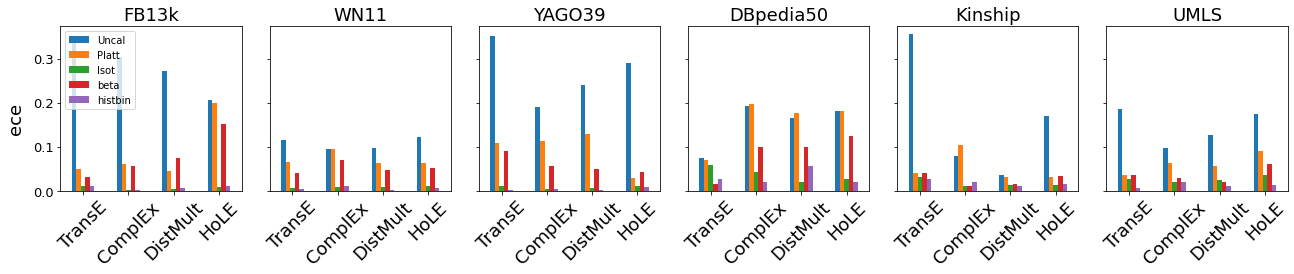

In [48]:
plot_metrics(ece)

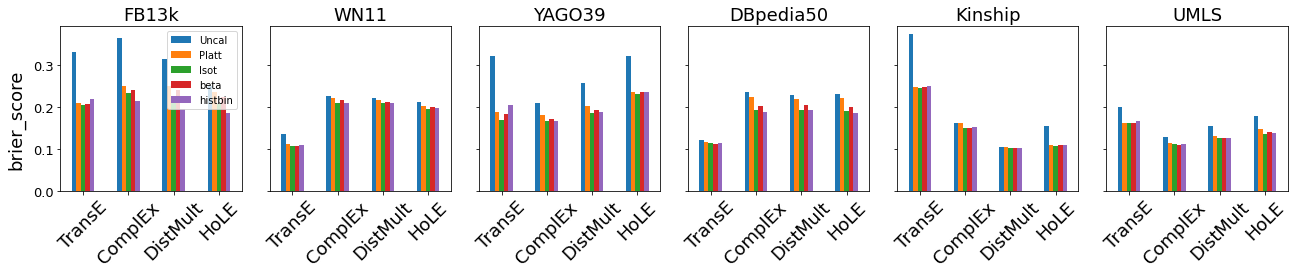

In [49]:
plot_metrics(brier_score)

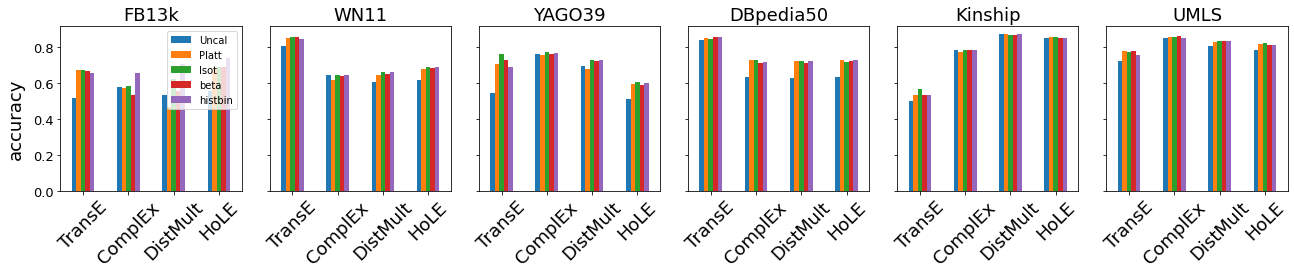

In [50]:
plot_metrics(accuracy)

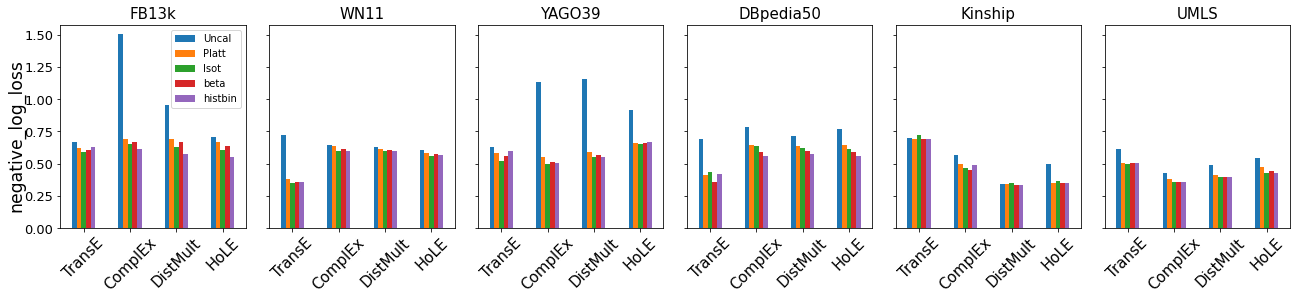

In [33]:
plot_metrics(negative_log_loss)

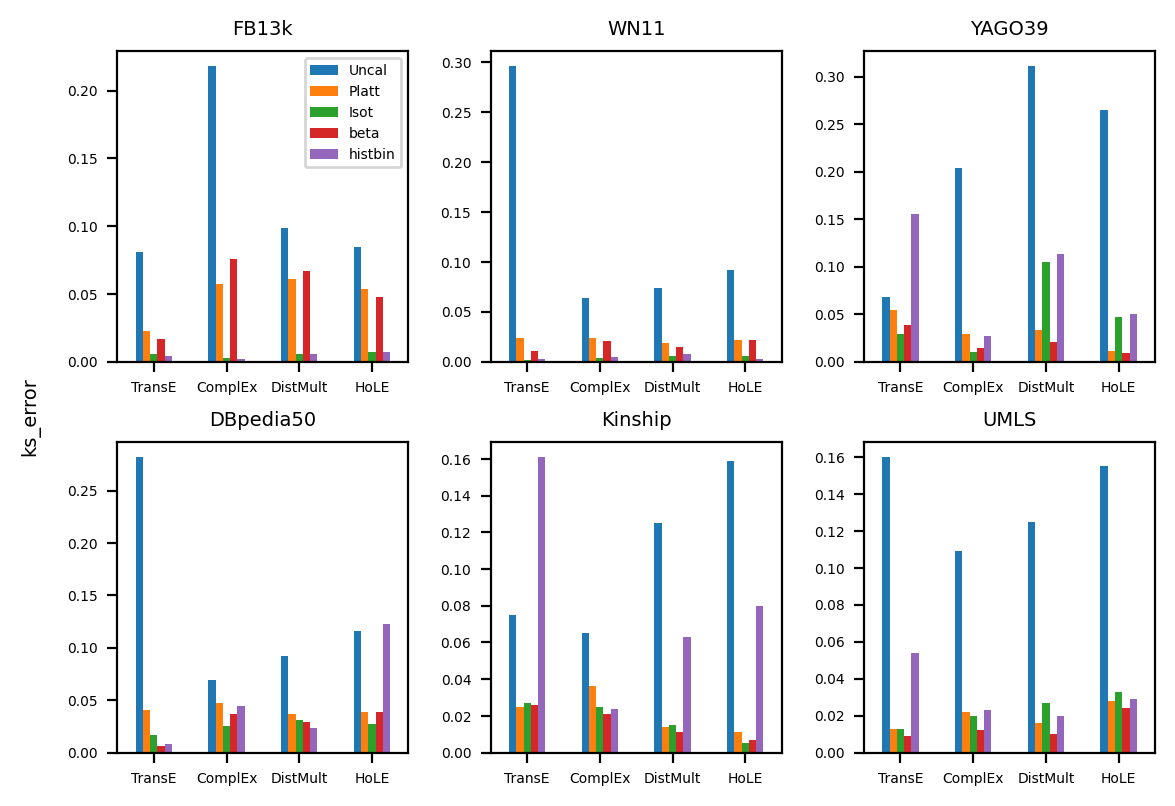

In [17]:
plot_metrics(ks_error)

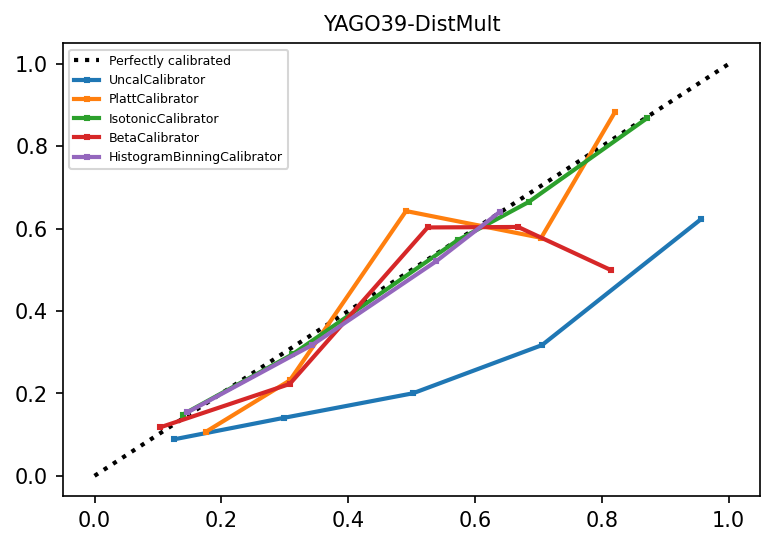

In [18]:
plt.rcParams['figure.dpi'] = 150 # default for me was 75
plt.rc('axes', labelsize=10)
plt.rc('axes', titlesize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=6)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=2)

data = exp.datasets[2]
kge = exp.trained_kges[data.name]['DistMult']
c = exp.trained_cals[data.name][kge.name].values()
plot_ds_kge_cals(data, kge, c)
plt.legend()

In [19]:
from sklearn.metrics import accuracy_score
def per_rel_threshold(model, data):
    scores = model.predict(data.X_test)
    val_scores = model.predict(data.X_valid)
    thresholds = {r: np.median(np.sort(val_scores[data.X_valid[:, 1] == r])) for r in np.unique(data.X_valid[:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(data.X_test[:, 1])
    per_relation_acc = accuracy_score(data.y_test, scores > thresholds_test)
    return per_relation_acc, thresholds

for data in exp.datasets:
    for kge in exp.trained_kges[data.name].values():
        try:
            print(f'{data.name} {kge.name}')
            print('    ', per_rel_threshold(kge, data)[0])
        except TypeError as err:
            print(err)

FB13k TransE
     0.6476698129108377
FB13k ComplEx
     0.44543232765885726
FB13k DistMult
     0.6007289735378392
FB13k HolE
     0.6818852182706894
WN11 TransE
     0.8249771643154369
WN11 ComplEx
     0.6203694306302648
WN11 DistMult
     0.618491829899523
WN11 HolE
     0.6408708007713387
YAGO39 TransE


c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


     0.7812719511536176
YAGO39 ComplEx


c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


     0.6962230507375587
YAGO39 DistMult


c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


     0.6373804506402982
YAGO39 HolE


c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


     0.5865888582698439
DBpedia50 TransE
'>' not supported between instances of 'float' and 'NoneType'
DBpedia50 ComplEx
'>' not supported between instances of 'float' and 'NoneType'
DBpedia50 DistMult
'>' not supported between instances of 'float' and 'NoneType'
DBpedia50 HolE
'>' not supported between instances of 'float' and 'NoneType'
Kinship TransE
     0.5586592178770949
Kinship ComplEx
     0.770949720670391
Kinship DistMult


c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


     0.8249534450651769
Kinship HolE
     0.8221601489757915
UMLS TransE
     0.7844175491679274
UMLS ComplEx


c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


     0.8207261724659607
UMLS DistMult
     0.7965204236006052
UMLS HolE
     0.8078668683812406


c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
c:\Users\s1904162\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
